In [3]:
#7.2.1. VGG 块
#经典卷积神经网络的基本组成部分是下面的这个序列： 
#1. 带填充以保持分辨率的卷积层； 1. 非线性激活函数，如ReLU； 1. 池化层，如最大池化层。

#该函数有三个参数，分别对应于卷积层的数量 num_convs、
#输入通道的数量 in_channels 和输出通道的数量 out_channels.
!pip install d2l
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [4]:
#7.2.2. VGG 网络
#原始 VGG 网络有 5 个卷积块，其中前两个块各有一个卷积层，后三个块各包含两个卷积层。 
#第一个模块有 64 个输出通道，每个后续模块将输出通道数量翻倍，直到该数字达到 512。
#由于该网络使用 8 个卷积层和 3 个全连接层，因此它通常被称为 VGG-11。
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(*conv_blks, nn.Flatten(),
                # 全连接层部分
                nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(),
                nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
                nn.Dropout(0.5), nn.Linear(4096, 10))

conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

In [5]:
#接下来，我们将构建一个高度和宽度为 224 的单通道数据样本，以观察每个层输出的形状。
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)
#正如你所看到的，我们在每个块的高度和宽度减半，最终高度和宽度都为7。最后再展平表示，送入全连接层处理。

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [6]:
#7.2.3. 训练
#由于 VGG-11 比 AlexNet 计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集。
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.175, train acc 0.935, test acc 0.914
679.4 examples/sec on cuda:0


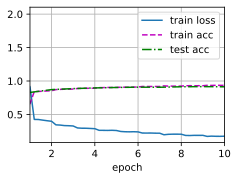

In [7]:
#除了使用略高的学习率外，模型训练过程与 7.1节 中的 AlexNet 类似。
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())